## Importing the Required Libraries

In [1]:
#!pip install seaborn

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Loading Images from the Disk

In [2]:
# Global Variables for later use

IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
# function that would read an image provided the image path, preprocess and return it back

def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) # resizing it to 128*128
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img

In [4]:
labels = ['real', 'fake']

X = [] # To store images
y = [] # To store labels

# labels -
# 0 - Real
# 1 - Fake
image_path = './dataset/' # path containing image samples

In [5]:
for folder in os.scandir(image_path):
    for entry in os.scandir(image_path + folder.name):

        X.append(read_and_preprocess(image_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='r':
            y.append(0) # real
        else:
            y.append(1) # fake

In [6]:
X = np.array(X)
X.shape # We have 1289 image samples in total

(10905, 128, 128, 3)

In [7]:
y = np.array(y)
y.shape

(10905,)

## Exploring the Dataset

<BarContainer object of 2 artists>

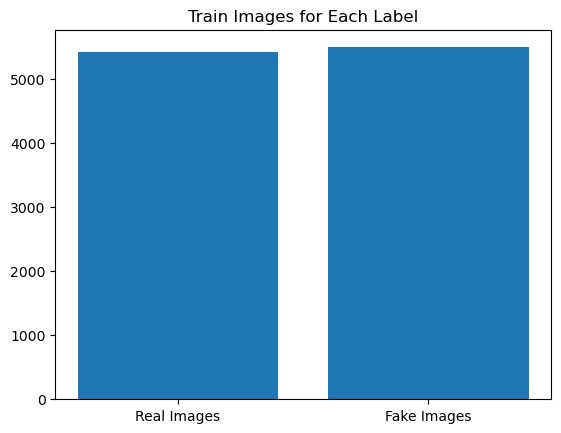

In [8]:
real_count = len(y[y==0])
fake_count = len(y[y==1])

plt.title("Train Images for Each Label")
plt.bar(["Real Images", "Fake Images"],[real_count, fake_count])

# We have more samples of Fake Images than Real Images

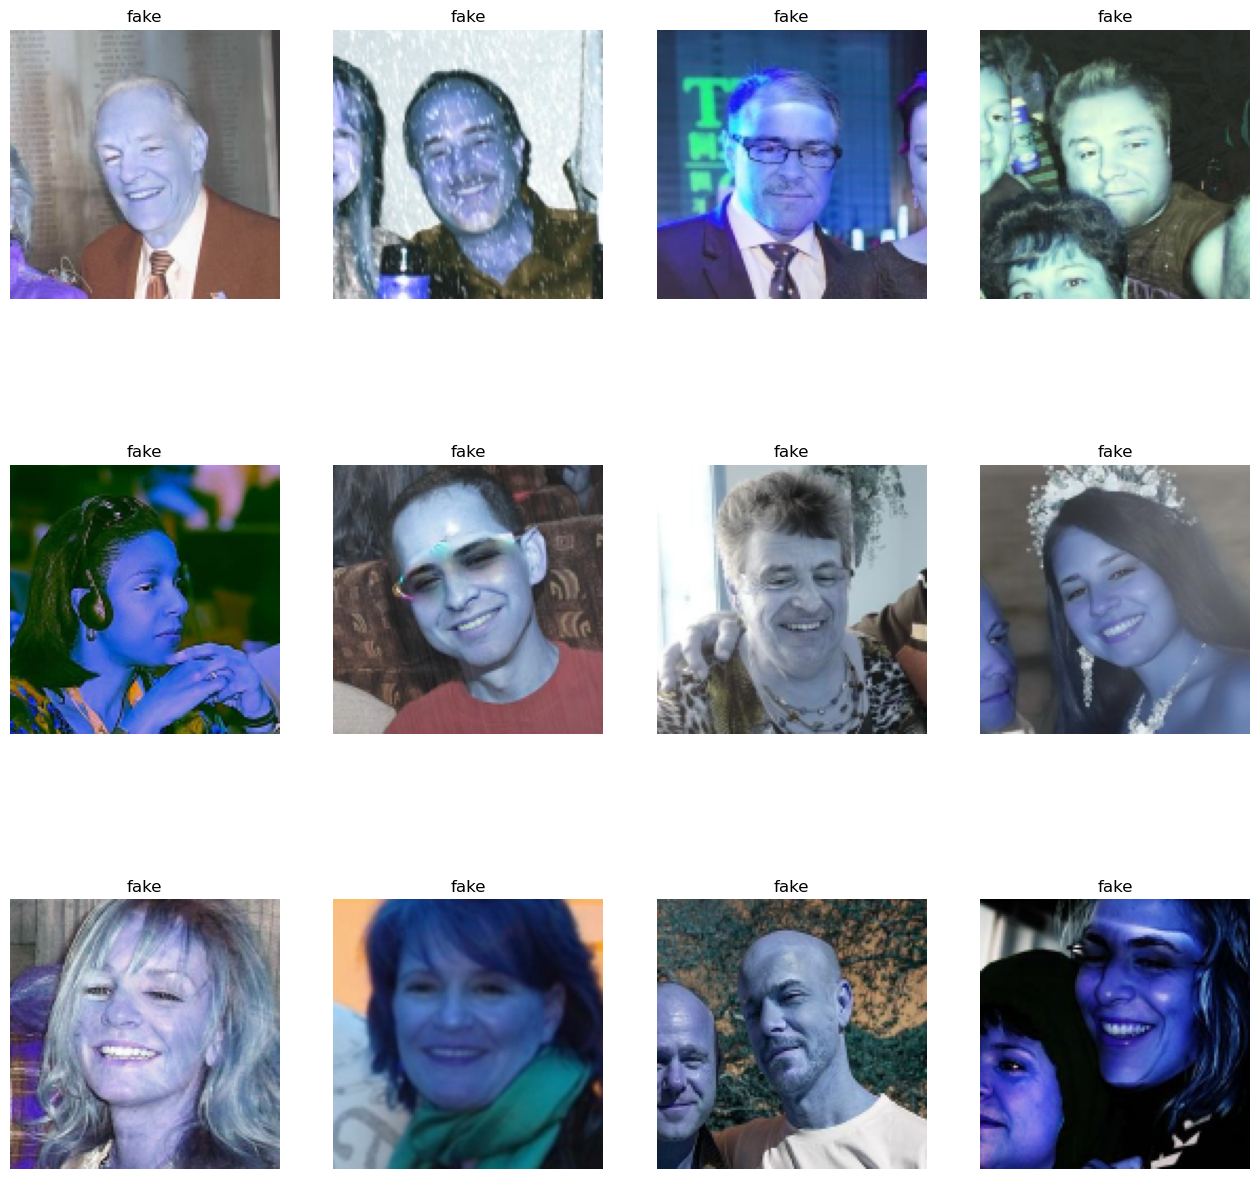

In [9]:
# plotting random images

import random

plt.figure(figsize=(16, 16))

for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.axis("off")
    img = random.randint(0, 1289)
    plt.imshow(X[img])
    plt.title(labels[y[img]])

## Splitting the dataset

We will take -
- 80% data for training our model
- 10% data for validation purpose
- 10% data for test purpose

In [10]:
from sklearn.model_selection import train_test_split

# We have splitted our data in a way that - 
# 1. The samples are shuffled
# 2. The ratio of each class is maintained (stratify)
# 3. We get same samples every time we split our data (random state)

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  shuffle=True, 
                                                  stratify=y, 
                                                  random_state=123)

In [11]:
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, 
                                                  test_size=0.5, 
                                                  shuffle=True, 
                                                  stratify=y_val, 
                                                  random_state=123)

In [12]:
# we are using 1031 images for training our model
X_train.shape

(8724, 128, 128, 3)

In [13]:
# we are using 129 images for validating our model
X_val.shape

(1091, 128, 128, 3)

In [14]:
# we are using 129 images for testing our model
X_test.shape

(1090, 128, 128, 3)

In [15]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

In [17]:
from tensorflow.keras.applications import VGG16

In [18]:
# loading the model 
#input_shape=(32, 32, 3)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
# include_top determines whether to include the fully connected layers at the top of the network.
vgg_model.summary()

58900480/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [19]:
# Freeze the layers of the VGG model
for layer in vgg_model.layers:
    layer.trainable = False

In [22]:
# adding the FC layers
# Dense layers 
# Create a new model by adding layers on top of VGG
model = tf.keras.Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
# to reduce overfitting 
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 16,814,666
Trainable params: 2,099,978
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [24]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train the model with EarlyStopping
history_1 = model.fit(train_images, train_labels, 
                    validation_data=(test_images, test_labels), 
                    epochs=50, batch_size=64,
                    callbacks=[early_stopping])

In [25]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="fake_weights.h5", verbose=1, save_best_only=True)

In [26]:
history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True, callbacks=[earlystopping, checkpointer])

Epoch 1/10
273/273 [==============================] - ETA: 0s - loss: 0.6561 - accuracy: 0.6721
Epoch 00001: val_loss improved from inf to 0.50870, saving model to fake_weights.h5
273/273 [==============================] - 194s 709ms/step - loss: 0.6561 - accuracy: 0.6721 - val_loss: 0.5087 - val_accuracy: 0.7424
Epoch 2/10
273/273 [==============================] - ETA: 0s - loss: 0.5003 - accuracy: 0.7517
Epoch 00002: val_loss improved from 0.50870 to 0.49586, saving model to fake_weights.h5
273/273 [==============================] - 202s 742ms/step - loss: 0.5003 - accuracy: 0.7517 - val_loss: 0.4959 - val_accuracy: 0.7369
Epoch 3/10
273/273 [==============================] - ETA: 0s - loss: 0.4706 - accuracy: 0.7725
Epoch 00003: val_loss improved from 0.49586 to 0.46812, saving model to fake_weights.h5
273/273 [==============================] - 198s 727ms/step - loss: 0.4706 - accuracy: 0.7725 - val_loss: 0.4681 - val_accuracy: 0.7599
Epoch 4/10
273/273 [===========================

In [29]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("fakevsreal_model.json","w") as json_file:
  json_file.write(model_json)

## Evaluating the Saved Model Performance

In [30]:
# Load pretrained model (best saved one)
with open('fakevsreal_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model weights  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('fake_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [31]:
# making predictions
predictions = model.predict(X_test)

In [32]:
# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [33]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
accuracy

0.7834862385321101